In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import plotly.express as px

import pandas as pd

In [47]:
class NetworkNode:
    
    def __init__(self, name):
        self.name = name
        self.is_compromised = 0
        self.flagged_malicious = 0
        self.level = 0
        
        self.packet_rate_array = []
        self.bandwidth_array = []
        self.response_time_array = []
        self.flagged_malicious_array = [0]
        self.compromised_array = [0]
        
        self.time_step_array = [-1]
        
        self.parent_nodes = []
        self.child_nodes = []
        
        self.cur_packet_rate = self.get_packet_rate()
        self.cur_bandwidth = self.get_bandwidth()
        self.cur_response_time = self.get_response_time()

        
    def get_packet_rate(self, mu=0.91, stdev=0.01, min_uniform=0.05, max_uniform=0.1):
        # Under normal operation, 
        if self.is_compromised ==0:
            packet_rate = np.random.normal(mu, stdev)
        else:
            packet_rate = np.random.normal(mu,stdev) - np.random.uniform(min_uniform, max_uniform)
        self.packet_rate_array.append(packet_rate)
        return packet_rate
    
    def get_bandwidth(self, mu=30, stdev=3, min_uniform=2, max_uniform=7):
        if self.is_compromised == 0:
            bandwidth = np.random.normal(mu, stdev)
        else:
            bandwidth = np.random.normal(mu, stdev) - np.random.uniform(min_uniform, max_uniform)
        self.bandwidth_array.append(bandwidth)
        return bandwidth
    
    def get_response_time(self, mu=130, stdev=20, min_uniform=100, max_uniform=300):
        if self.is_compromised == 0:
            response_time = np.random.normal(mu, stdev)
        else:
            response_time = np.random.normal(mu, stdev) + np.random.uniform(min_uniform, max_uniform)
        self.response_time_array.append(response_time)
        return response_time
        
    def link_nodes(self, parent_node_list, child_node_list):
        for node in parent_node_list:
            self.parent_nodes.append(node)
        for node in child_node_list:
            self.child_nodes.append(node)
            
    def get_node_metrics(self, timestep):
        self.time_step_array.append(timestep)
        self.cur_packet_rate = self.get_packet_rate()
        self.cur_bandwidth = self.get_bandwidth()
        self.cur_response_time = self.get_response_time()

    def set_node_level(self, level):
        self.level=level
        
    def get_node_level(self):
        return self.level
    
    def add_timestep(self, t):
        self.time_step_array.append(t)
    
    def basic_compromise_check(self):
        self.flagged_malicious = 0
        if (self.cur_response_time > 130) & (self.cur_bandwidth < 32):
            if self.cur_packet_rate < 0.905:
                self.flagged_malicious = 1

            
        if (self.cur_response_time > 130) & (self.cur_packet_rate < 0.91):
            if self.cur_bandwidth < 27:
                self.flagged_malicious = 1


        '''
        # Reset the node to non-malicious if the metrics look good 
        if (self.cur_response_time < 130) & (self.cur_packet_rate > 0.91) & (self.cur_bandwidth > 30):
            self.flagged_malicious = 0
        '''

        self.flagged_malicious_array.append(self.flagged_malicious)
        self.compromised_array.append(self.is_compromised)

In [48]:
class Simulation:
    
    def __init__(self, name):
        self.name = name
        self.node_list = []
        
    def run_simulation(self, t):
        for timestep in range(0, t):
            for n in self.node_list:
                n.get_node_metrics(timestep)
                n.basic_compromise_check()
        
        sim_results = {}
        for n in self.node_list:
            sim_results[n.name] = {'time': n.time_step_array,
                                'packet_rate': n.packet_rate_array,
                                   'bandwidth': n.bandwidth_array,
                                   'response_time': n.response_time_array,
                                   'flagged_malicious': n.flagged_malicious_array,
                                  'compromised_truth': n.compromised_array}
        return sim_results

        
    def establish_nodes(self, num_nodes):
        node_dict = {}
        for i in range(0,num_nodes):
            node_name = f'node_{i}'
            node = NetworkNode(node_name)
            self.node_list.append(node)
            node_dict[node_name] = i
        return node_dict
            
    def get_node(self, node_name):
        node = None
        ind=0
        for n in self.node_list:
            if n.name==node_name:
                node = n
                break
            ind+=1
        return node,ind
            
    def modify_node(self, node, ind):
        self.node_list[ind] = node
            
    def set_network_structure(self, node_name):
        node = None
        for n in self.node_list:
            if n.name==node_name:
                n.name='test'
                
    def set_v1_structure(self):
        self.node_list[0].set_node_level(0)
        self.node_list[0].link_nodes([], [self.node_list[1], self.node_list[2]])

        self.node_list[1].set_node_level(1)
        self.node_list[1].link_nodes([self.node_list[0]], [self.node_list[3]])
        self.node_list[2].set_node_level(1)
        self.node_list[2].link_nodes([self.node_list[0]], [self.node_list[4],self.node_list[5]])

        self.node_list[3].set_node_level(2)
        self.node_list[3].link_nodes([self.node_list[1]], [self.node_list[6], self.node_list[7]])
        self.node_list[4].set_node_level(2)
        self.node_list[4].link_nodes([self.node_list[2]], [])
        self.node_list[5].set_node_level(2)
        self.node_list[5].link_nodes([self.node_list[2]], [self.node_list[8]])

        self.node_list[6].set_node_level(3)
        self.node_list[6].link_nodes([self.node_list[3]], [])
        self.node_list[7].set_node_level(3)
        self.node_list[7].link_nodes([self.node_list[3]], [])
        self.node_list[8].set_node_level(3)
        self.node_list[8].link_nodes([self.node_list[5]], [])

In [49]:
    def get_node(self, node_name):
        node = None
        ind=0
        for n in self.node_list:
            if n.name==node_name:
                node = n
                break
            ind+=1
        return node,ind
            
    def modify_node(self, node, ind):
        self.node_list[ind] = node

In [50]:
# Run the simulation without a hacked node
sim = Simulation('sim1')
node_dict = sim.establish_nodes(9)
sim.set_v1_structure()
uncompromised_results = sim.run_simulation(t=100)

In [51]:
# Run the simulation with node 0 hacked
sim = Simulation('sim1')
node_dict = sim.establish_nodes(9)
sim.set_v1_structure()

node0, ind = sim.get_node('node_0')
node0.is_compromised = 1
sim.modify_node(node0, ind)

compromised_results = sim.run_simulation(t=100)

In [52]:
df_c = pd.DataFrame(compromised_results['node_0'])
df_u = pd.DataFrame(uncompromised_results['node_0'])

print(len(df_c[df_c.flagged_malicious==True]))
print(len(df_u[df_u.flagged_malicious==True]))

97
12


In [81]:
'''
Establish variables for Compromised Controller
'''

response_time = ctrl.Antecedent(np.arange(0,600,10), 'response_time')
packet_rate = ctrl.Antecedent(np.arange(0.83,0.93,0.005), 'packet_rate')
bandwidth = ctrl.Antecedent(np.arange(5,35,1), 'bandwidth')

compromised = ctrl.Consequent(np.arange(0,11), 'compromised')

response_time.automf(3)
packet_rate.automf(3)
bandwidth.automf(3)

compromised['green'] = fuzz.trimf(compromised.universe, [0,0,4])
compromised['yellow'] = fuzz.trimf(compromised.universe, [3,7,11])
compromised['red'] = fuzz.trimf(compromised.universe, [8,11,11])


In [82]:
rule1 = ctrl.Rule(response_time['poor'] & bandwidth['poor'], compromised['red'])
rule1a = ctrl.Rule(response_time['poor'] & packet_rate['poor'], compromised['red'])
rule2 = ctrl.Rule(response_time['poor'] | packet_rate['poor'] | bandwidth['poor'], compromised['red'])
rule3 = ctrl.Rule(packet_rate['average'] & response_time['average'], compromised['yellow'])
rule4 = ctrl.Rule(packet_rate['average'] | bandwidth['average'], compromised['yellow'])
rule5 = ctrl.Rule(response_time['good'] & bandwidth['good'], compromised['green'])
rule6 = ctrl.Rule(response_time['good'] & packet_rate['good'], compromised['green'])

In [83]:
compromised_ctrl = ctrl.ControlSystem([rule1, rule1a, rule2, rule3, rule4, rule5, rule6])
compromised_sim = ctrl.ControlSystemSimulation(compromised_ctrl)

In [84]:
compromised_sim.input['packet_rate']=1

In [85]:
c_arr= []
u_arr = []

for index, row in df_c.iterrows():
    p = row['packet_rate']
    b = row['bandwidth']
    r = 600 - row['response_time']
    
    compromised_sim.input['packet_rate'] = p
    compromised_sim.input['bandwidth'] = b
    compromised_sim.input['response_time'] = r
    
    compromised_sim.compute()
    
    result = compromised_sim.output['compromised']
    c_arr.append(result)
    
for index, row in df_u.iterrows():
    p = row['packet_rate']
    b = row['bandwidth']
    r = 600 - row['response_time']
    
    compromised_sim.input['packet_rate'] = p
    compromised_sim.input['bandwidth'] = b
    compromised_sim.input['response_time'] = r
    
    compromised_sim.compute()
    
    result = compromised_sim.output['compromised']
    u_arr.append(result)

# Backup

In [697]:
node_0_results = results['node_0']

In [698]:
df = pd.DataFrame(node_0_results)
df.head()

,time,packet_rate,bandwidth,response_time,flagged_malicious,compromised_truth
0,-1,0.917189,26.988047,131.993778,0,0
1,0,0.905484,29.588129,100.428653,0,0
2,1,0.903239,30.685591,116.571841,0,0
3,2,0.906371,34.955323,166.891895,0,0
4,3,0.920985,31.569331,132.348610,0,0


In [699]:
print(df.flagged_malicious.unique())
print(min(df.packet_rate))
print(max(df.packet_rate))
print(min(df.response_time))
print(max(df.response_time))
print(min(df.bandwidth))
print(max(df.bandwidth))

[0 1]
0.8897370048543322
0.9316159570172404
76.78765214562466
177.77614392607816
23.166697905816896
36.018002611184315


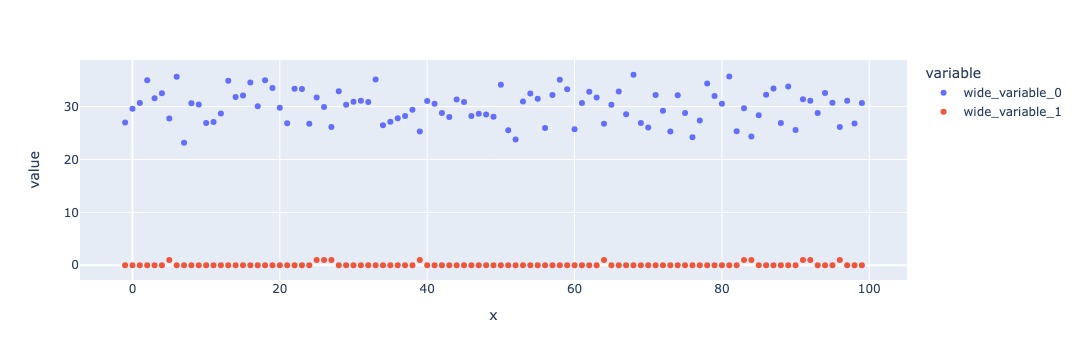

In [700]:
px.scatter(x=df.time, y=[df.bandwidth, df.flagged_malicious])

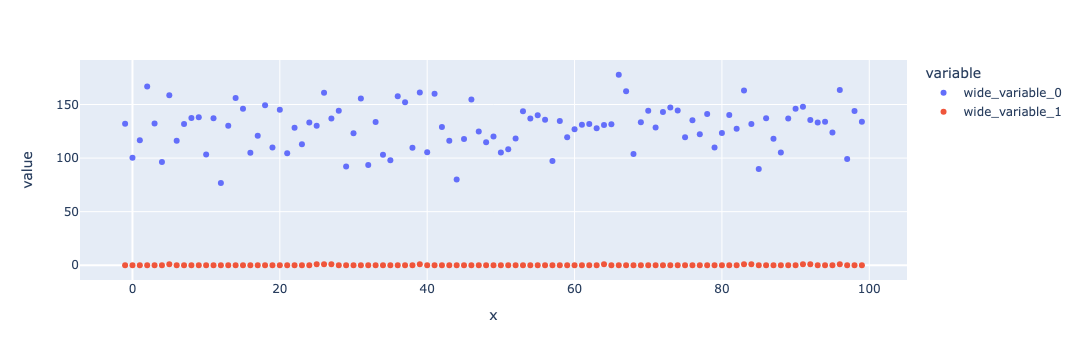

In [701]:
px.scatter(x=df.time, y=[df.response_time, df.flagged_malicious])

In [714]:
df_c = pd.DataFrame(compromised_results['node_0'])
df_u = pd.DataFrame(uncompromised_results['node_0'])

In [715]:
len(df_c[df_c.flagged_malicious==True])

10

In [716]:
len(df_u[df_c.flagged_malicious==True])

10